# Consumption-Savings with Deep Learning methods

In [31]:
import tensorflow as tf
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass

In [32]:
# Model parameters
α = 0.36
δ = 0.025
γ = 2.0
β = 0.99
σ = 0.0001
Kss = ((1/β+δ-1)/α)**(1/(α-1))
print(Kss)
wmin=Kss*0.9
wmax=Kss*1.1
print(Kss, wmin, wmax)

37.98925353815241
37.98925353815241 34.19032818433717 41.788178891967654


Text(0.5, 1.0, 'test')

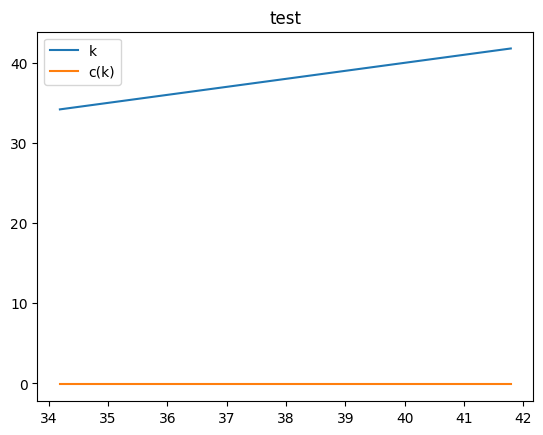

In [33]:
min_FB = lambda a,b: a+b-tf.sqrt(a**2+b**2)
layers = [
    tf.keras.layers.Dense(32, activation='relu', input_dim=2, bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

def model(y:Vector,w:Vector)->Tuple[Vector]:
    y = y/σ/2.0
    w = (w-Kss)/(Kss*0.5)
    s = tf.concat([i[:,None] for i in [y,w]],axis=1)
    c = perceptron(s)
    return c

wvec = np.linspace(wmin,wmax,500,dtype='float32')
shvec = model(wvec*0,wvec*0)
plt.plot(wvec, wvec, label = 'k')
plt.plot(wvec, shvec, label = 'c(k)')
plt.legend()
plt.title('test')

In [34]:
def residuals(e:Vector,y:Vector,w:Vector):
    n = tf.size(y)
    c=model(y,w)
    yp=e
    wp=tf.exp(y)*w**α+(1-δ)*w-c
    cp=model(yp,wp)
    R = c**(-γ) - β*(cp)**(-γ)*(α*wp**(α-1)+(1-δ))
    return (R)

residuals(wvec,wvec,wvec)

InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Ranks of all input tensors should match: shape[0] = [500,1] vs. shape[1] = [500,1,500] [Op:ConcatV2] name: concat

In [22]:
def J(n):
    y = tf.random.normal(shape=(n,),stddev=σ)
    w = tf.random.uniform(shape=(n,),minval=wmin,maxval=wmax)
    e1 = tf.random.normal(shape=(n,),stddev=σ)
    e2 = tf.random.normal(shape=(n,),stddev=σ)
    R1_e1 = residuals(e1, y, w)
    R1_e2 = residuals(e2, y, w)
    R_squared = R1_e1*R1_e2
    return tf.reduce_mean(R_squared)

In [23]:
n = 128
v = J(100)
v.numpy()

0.008307188

In [24]:
θ = perceptron.trainable_variables
print(str(θ)[:1000])

[<tf.Variable 'dense_12/kernel:0' shape=(2, 32) dtype=float32, numpy=
array([[ 0.3186966 ,  0.40605453, -0.22322242, -0.1575368 ,  0.11751053,
        -0.29022026,  0.384802  , -0.231176  , -0.19704759, -0.10644042,
        -0.3386976 , -0.19188015,  0.32938793, -0.2543906 , -0.39972344,
        -0.2805894 ,  0.26154247,  0.11518404,  0.27124372,  0.26288906,
         0.17400613,  0.23768005,  0.17337158,  0.11991361, -0.12299618,
        -0.23458941,  0.1630368 ,  0.3083057 , -0.38403013, -0.05817282,
         0.19361016, -0.354205  ],
       [-0.3294436 ,  0.20781085, -0.28178313, -0.28765386, -0.0814344 ,
         0.3181521 ,  0.23970875, -0.11837089,  0.12143686,  0.19492629,
         0.01160806, -0.40557745,  0.1890063 ,  0.16857901,  0.04396611,
         0.29654053,  0.35355523,  0.00943267,  0.10897055,  0.22614458,
        -0.09294733,  0.27201435,  0.21768793,  0.15720227, -0.37377095,
         0.15217885, -0.22535674, -0.06768161,  0.26630405, -0.31303227,
         0.18026266

In [25]:
from tensorflow.keras.optimizers import Adam, SGD
variables = perceptron.trainable_variables
optimizer = Adam()

In [26]:
@tf.function
def training_step():
    
    with tf.GradientTape() as tape:
        xx = J(n)
        
    grads = tape.gradient(xx,θ)
    optimizer.apply_gradients(zip(grads,θ))
    
    return xx

def train_me(K):
    vals=[]
    for k in tqdm(tf.range(K)):
        val=training_step()
        vals.append(val.numpy())
    return vals

results = train_me(5000)

100%|██████████████████████████████████████| 5000/5000 [00:10<00:00, 472.69it/s]


/var/folders/xt/r947d5fd2yz1_fkptq29sn8r0000gn/T/ipykernel_1260/3593405677.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


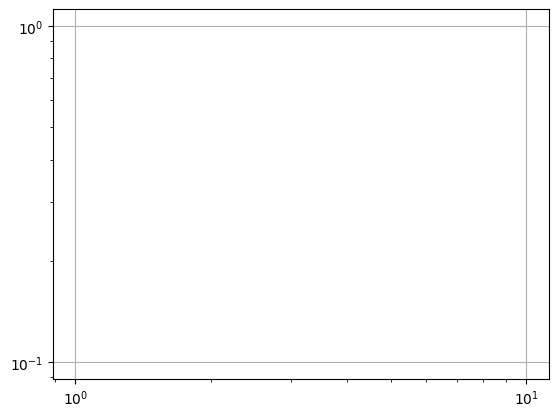

In [27]:
plt.plot(np.sqrt(results))
plt.xscale('log')
plt.yscale('log')
plt.grid()

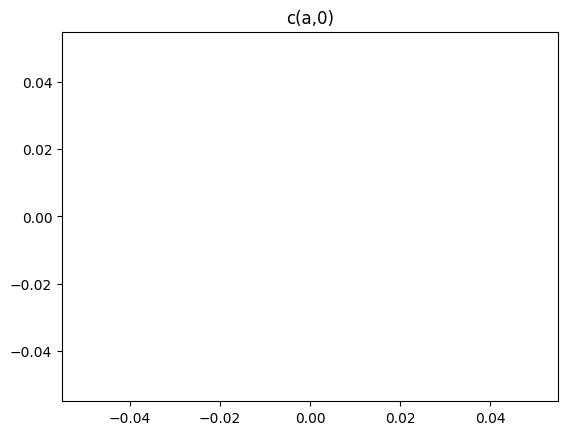

In [28]:
wvec = np.linspace(wmin,wmax,100,dtype='float32')
shvec = model(wvec*0,wvec)
plt.title('c(a,0)')
plt.plot(wvec,shvec, label = "k(k,z)")
plt.show()

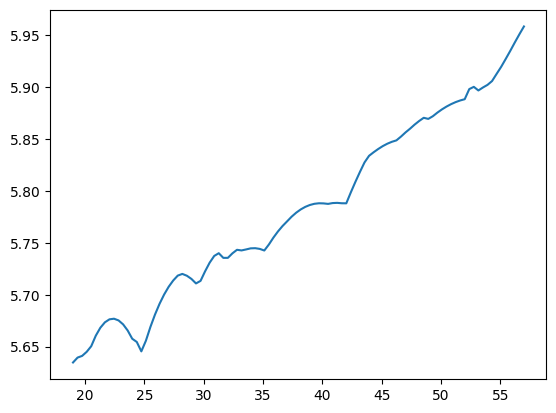

In [71]:
plt.plot(wvec,shvec*wvec, label = 'c(k,z)')